In [1]:
# %% [markdown]
# # Seattle Weather Category Prediction - Jupyter Notebook
#
# ## This notebook aims to predict the weather category (e.g., sun, rain, snow)
# # based on other meteorological features. It follows a structure similar to
# # the provided Kaggle example, using Gaussian Naive Bayes.
#
# ## Steps:
# (Original numbered steps removed as per feedback, structure implied by headers)
# - Load and Explore Data
# - Visualize Data
# - Preprocess Data (Label Encoding for target, add lagged features)
# - Train and Evaluate Models
# - Conduct Ablation Study
# - Save the Model and Label Encoder for Flask App

# %% [markdown]
# ## Setup and Load Data

# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io # To load CSV from string in some environments (not strictly used by pd.read_csv here)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
# %%
# Display plots inline
%matplotlib inline
# Set some display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
# %% [markdown]
# ### Helper Functions

# %%
def print_header(message):
    """Prints a formatted header message."""
    print(f"\n{message}:")

def load_and_preprocess_data(file_path):
    """Loads the dataset and performs initial date conversion."""
    df = pd.read_csv(file_path)
    print_header("Dataset loaded successfully")
    df['date'] = pd.to_datetime(df['date']) # Convert date column to datetime
    return df

def create_visualization_df(dataframe):
    """Creates a copy of the dataframe for visualization and extracts year/month."""
    df_vis = dataframe.copy()
    df_vis['year'] = df_vis['date'].dt.year
    df_vis['month'] = df_vis['date'].dt.month
    return df_vis

In [4]:
# --- Feedback Implementation: Helper Defaults and Splitting ---
_DEFAULT_FEATURES_TO_LAG = ("precipitation", "temp_max", "temp_min", "wind", "weather_encoded")
_DEFAULT_TEMP_FEATURES_FOR_DELTA = ("temp_max", "temp_min")

def _create_lag_features(df_input, features_to_lag=_DEFAULT_FEATURES_TO_LAG, lag_period=1):
    """
    Adds lagged versions of specified features.
    Sorts by 'date' column if present before lagging.
    """
    df_out = df_input.copy()

    if 'date' in df_out.columns:
        df_out = df_out.sort_values(by='date').reset_index(drop=True) # Sort and reset index
    else:
        print("Warning: 'date' column not present for sorting in _create_lag_features. Assuming pre-sorted data for lag features.")

    for feature in features_to_lag:
        if feature in df_out.columns:
            df_out[f'{feature}_lag{lag_period}'] = df_out[feature].shift(lag_period)
        else:
            print(f"Warning: Feature '{feature}' not found in DataFrame for lagging.")
    return df_out # Returns DataFrame with NaNs from shifting

In [5]:
def _create_delta_features(df_input, temp_features_for_delta=_DEFAULT_TEMP_FEATURES_FOR_DELTA, lag_period=1):
    """
    Adds delta (difference) features for specified temperature-like features.
    Assumes df_input already contains the necessary current and lagged features.
    """
    df_out = df_input.copy()

    for temp_feature in temp_features_for_delta:
        current_feature_name = temp_feature
        lagged_feature_name = f'{temp_feature}_lag{lag_period}'

        if current_feature_name in df_out.columns and lagged_feature_name in df_out.columns:
            df_out[f'delta_{temp_feature}'] = df_out[current_feature_name] - df_out[lagged_feature_name]
        else:
            if current_feature_name not in df_out.columns:
                 print(f"Warning: Current feature {current_feature_name} not found for delta calculation.")
            if lagged_feature_name not in df_out.columns:
                 print(f"Warning: Lagged feature {lagged_feature_name} not found for delta calculation of {current_feature_name}.")
    return df_out

In [6]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, target_names, model_name="Model"):
    """Trains a model and prints evaluation metrics."""
    print_header(f"--- {model_name} Training and Evaluation ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print_header("Confusion Matrix")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print_header("Classification Report")
    print(classification_rep)
    return model, accuracy

In [7]:
# %%
# --- Load the dataset ---
file_path = 'seattle-weather.csv'
df = load_and_preprocess_data(file_path)
df.head()


Dataset loaded successfully:


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [8]:
# %% [markdown]
# ## Initial Data Exploration & Visualization

# %%
print_header("Dataset Info")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB


In [9]:
# %%
print_header("Statistical Summary")
print(df.describe())


Statistical Summary:
                      date  precipitation     temp_max     temp_min         wind
count                 1461    1461.000000  1461.000000  1461.000000  1461.000000
mean   2013-12-31 00:00:00       3.029432    16.439083     8.234771     3.241136
min    2012-01-01 00:00:00       0.000000    -1.600000    -7.100000     0.400000
25%    2012-12-31 00:00:00       0.000000    10.600000     4.400000     2.200000
50%    2013-12-31 00:00:00       0.000000    15.600000     8.300000     3.000000
75%    2014-12-31 00:00:00       2.800000    22.200000    12.200000     4.000000
max    2015-12-31 00:00:00      55.900000    35.600000    18.300000     9.500000
std                    NaN       6.680194     7.349758     5.023004     1.437825


In [10]:
# %%
print_header("Missing Values Check")
print(df.isnull().sum())
print(f"Any NA values present: {df.isna().sum().any()}")


Missing Values Check:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64
Any NA values present: False


In [11]:
# %%
print_header("Duplicate Rows Check")
print(f"Number of duplicated rows: {df.duplicated().sum()}")


Duplicate Rows Check:
Number of duplicated rows: 0


In [12]:
# %%
print_header("Day with Minimum temp_min")
print(df[df['temp_min']==min(df.temp_min)])


Day with Minimum temp_min:
          date  precipitation  temp_max  temp_min  wind weather
706 2013-12-07            0.0       0.0      -7.1   3.1     sun


In [13]:
# %%
print_header("Day with Maximum temp_max")
print(df[df['temp_max']==max(df.temp_max)])


Day with Maximum temp_max:
          date  precipitation  temp_max  temp_min  wind weather
953 2014-08-11            0.5      35.6      17.8   2.6    rain


In [14]:
# %%
t_min_overall = pd.concat([df['temp_min'], df['temp_max']]).min()
t_max_overall = pd.concat([df['temp_min'], df['temp_max']]).max()
bins = np.arange(np.floor(t_min_overall), np.ceil(t_max_overall) + 1, 1)


C:\Users\MY\AppData\Local\Temp\ipykernel_19644\827303715.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='temp_max', bins=bins, kde=True, palette="viridis") # Using palette instead of color for histplot


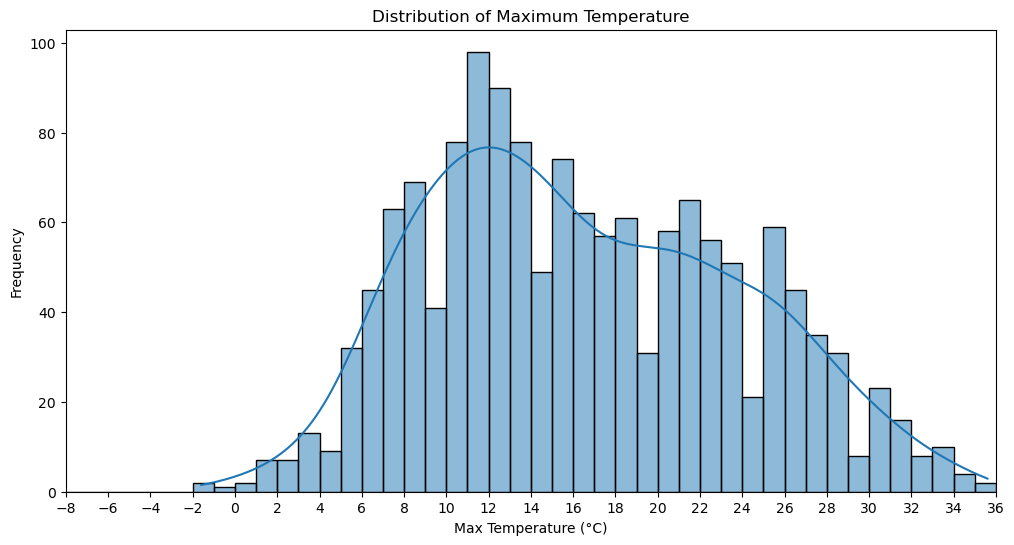

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='temp_max', bins=bins, kde=True, palette="viridis") # Using palette instead of color for histplot
plt.title('Distribution of Maximum Temperature')
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Frequency')
plt.xlim(bins.min(), bins.max())
plt.xticks(bins[::2])
plt.show()

C:\Users\MY\AppData\Local\Temp\ipykernel_19644\1569620151.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='temp_min', bins=bins, kde=True, palette="viridis") # Using palette instead of color for histplot


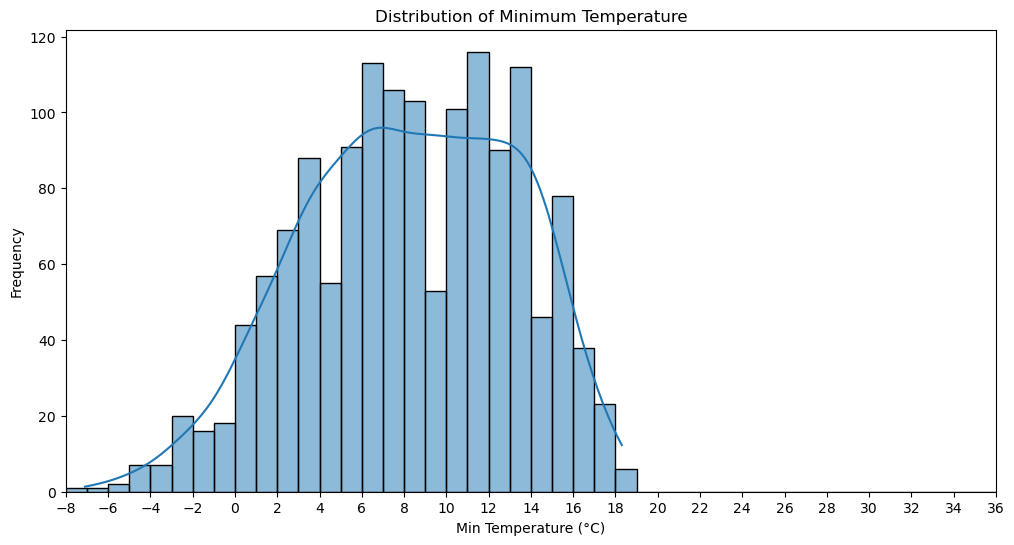

In [16]:
# %%
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='temp_min', bins=bins, kde=True, palette="viridis") # Using palette instead of color for histplot
plt.title('Distribution of Minimum Temperature')
plt.xlabel('Min Temperature (°C)')
plt.ylabel('Frequency')
plt.xlim(bins.min(), bins.max())
plt.xticks(bins[::2])
plt.show()

In [17]:
# %% [markdown]
# ### FacetGrid Visualizations (Month vs. Weather Variables by Year)

# %%
df_vis = create_visualization_df(df)

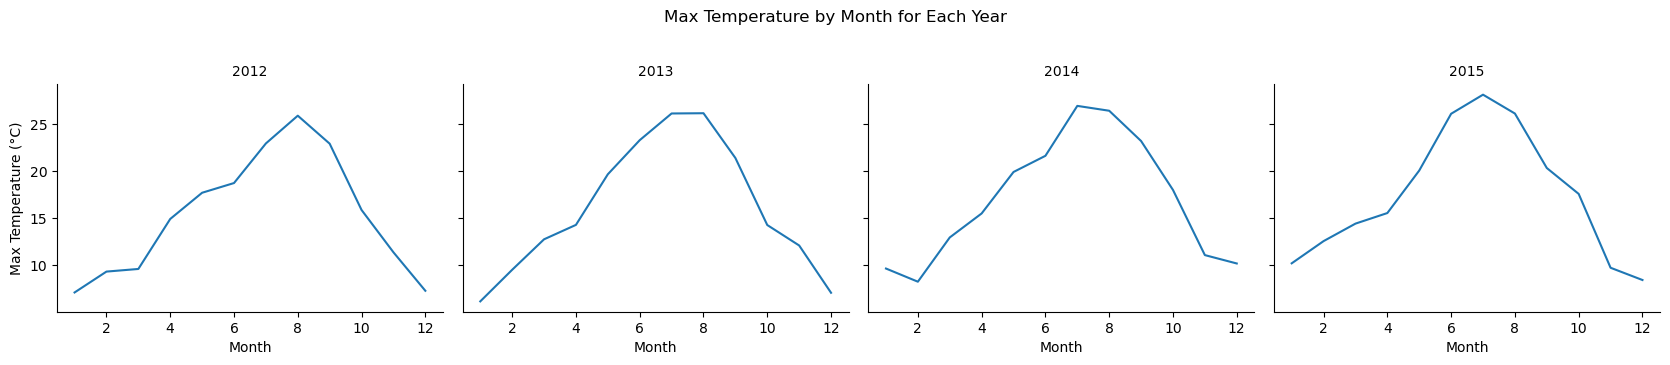

In [18]:
# %%
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'temp_max', errorbar=None)
g.set_axis_labels('Month', 'Max Temperature (°C)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Max Temperature by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

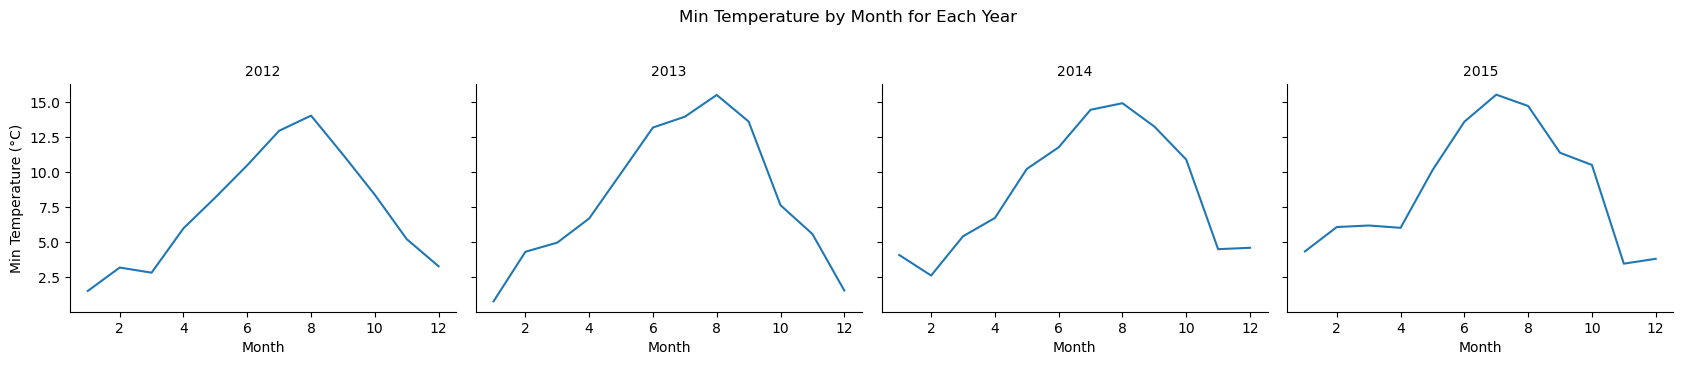

In [19]:
# %%
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'temp_min', errorbar=None)
g.set_axis_labels('Month', 'Min Temperature (°C)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Min Temperature by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

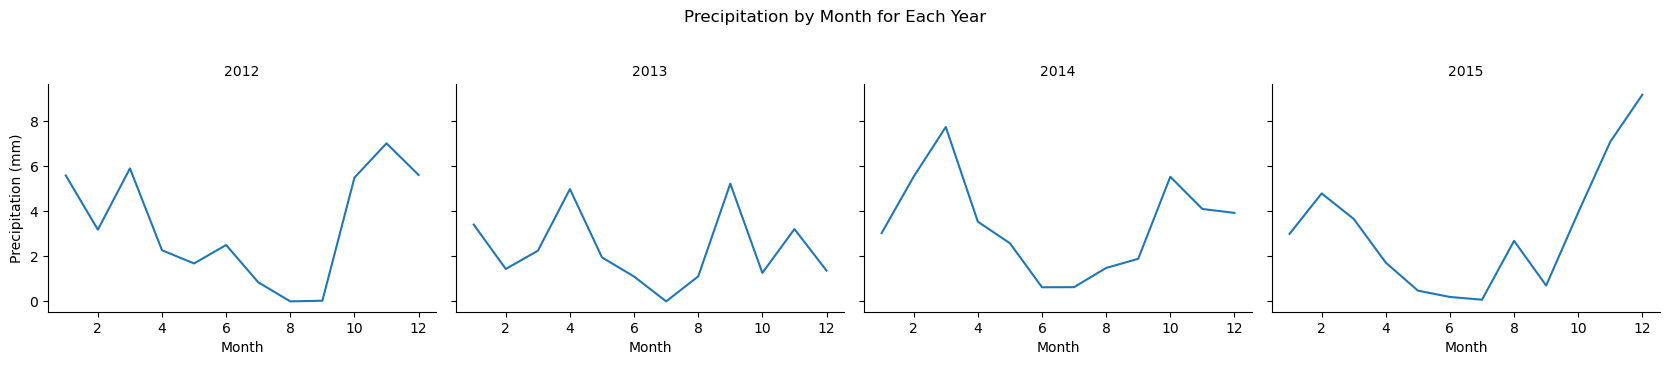

In [20]:
# %%
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'precipitation', errorbar=None)
g.set_axis_labels('Month', 'Precipitation (mm)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Precipitation by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

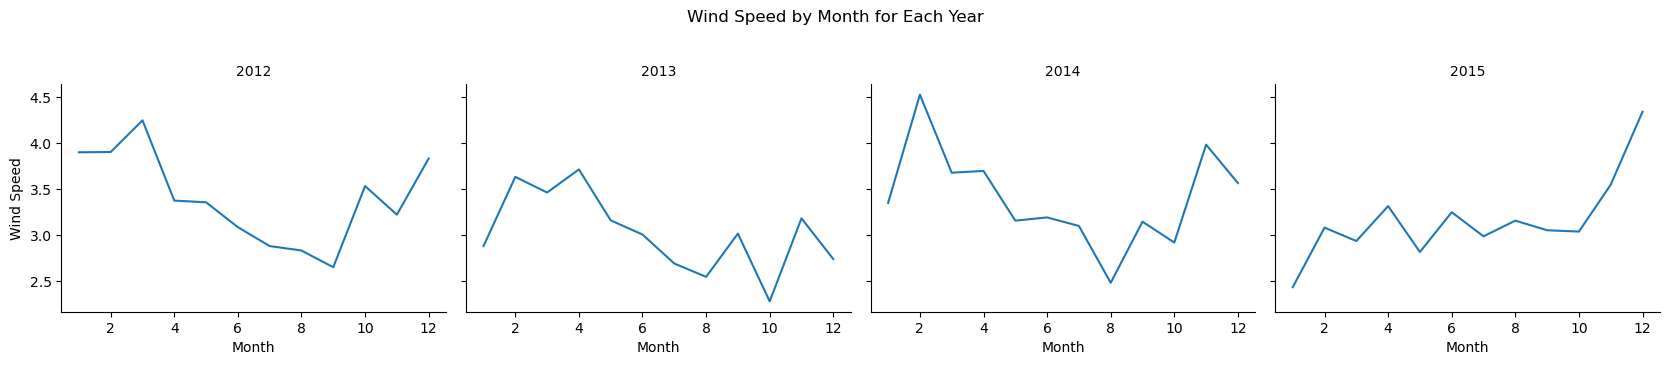

In [21]:
# %%
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'wind', errorbar=None)
g.set_axis_labels('Month', 'Wind Speed')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Wind Speed by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

In [22]:
# %% [markdown]
# ### Weather Category Distribution

# %%
print_header("Weather Category Counts")
weather_counts = df['weather'].value_counts()
print(weather_counts)


Weather Category Counts:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64


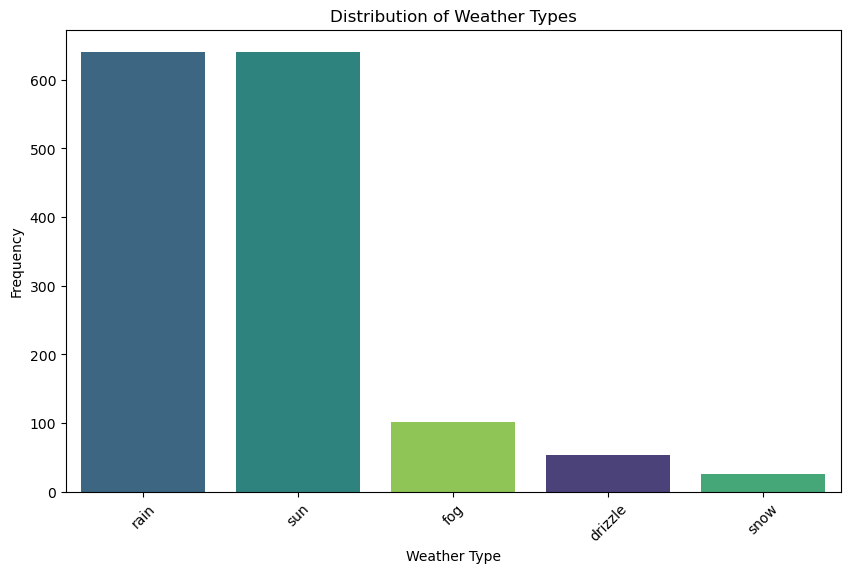

In [23]:
# %%
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='weather', order=weather_counts.index, hue='weather', palette="viridis", legend=False)
plt.title('Distribution of Weather Types')
plt.xlabel('Weather Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

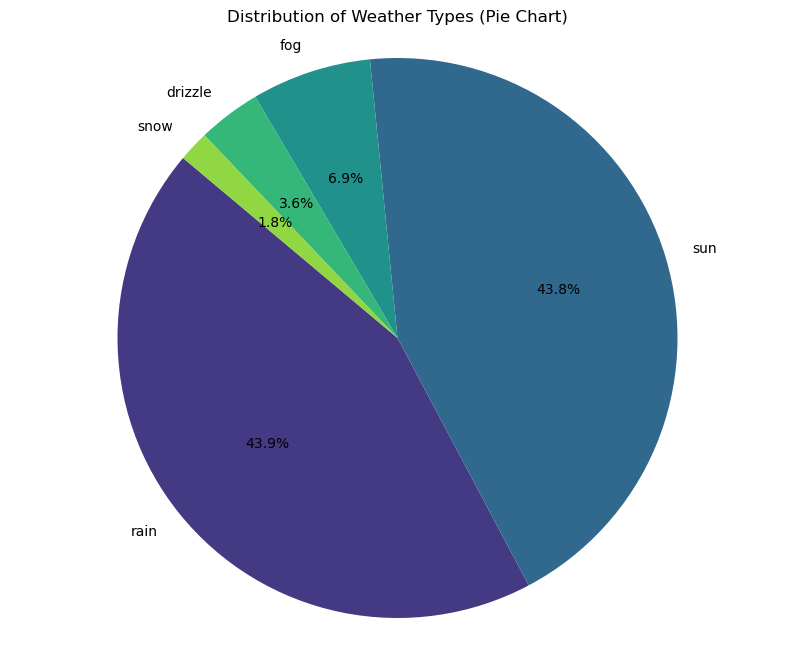

In [24]:
# %%
plt.figure(figsize=(10, 8))
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette("viridis", len(weather_counts)))
plt.title('Distribution of Weather Types (Pie Chart)')
plt.axis('equal')
plt.show()

In [25]:
# %% [markdown]
# ## Data Preprocessing for Classification

# %%
df_processed = df.copy()
if 'date' in df_processed.columns:
    df_processed = df_processed.drop('date', axis=1)

print_header("DataFrame columns before modeling")
print(df_processed.columns.tolist())
df_processed.head()


DataFrame columns before modeling:
['precipitation', 'temp_max', 'temp_min', 'wind', 'weather']


,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


In [26]:
# %%
le = LabelEncoder()
df_processed['weather_encoded'] = le.fit_transform(df_processed['weather'])

print_header("Label Encoding Mapping for 'weather'")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")


Label Encoding Mapping for 'weather':
drizzle -> 0
fog -> 1
rain -> 2
snow -> 3
sun -> 4


In [27]:
# %%
joblib.dump(le, 'weather_label_encoder.joblib')
print_header("Saved weather_label_encoder.joblib")
df_processed.head()


Saved weather_label_encoder.joblib:


,precipitation,temp_max,temp_min,wind,weather,weather_encoded
0,0.0,12.8,5.0,4.7,drizzle,0
1,10.9,10.6,2.8,4.5,rain,2
2,0.8,11.7,7.2,2.3,rain,2
3,20.3,12.2,5.6,4.7,rain,2
4,1.3,8.9,2.8,6.1,rain,2


In [28]:
# %% [markdown]
# ### Adding Lagged Time Series Features

# %%
df_for_lagged_processing = df.copy() # Start with the original df that includes 'date'

le_lagged = LabelEncoder() # Use a separate encoder if necessary, or ensure le can be reused
df_for_lagged_processing['weather_encoded'] = le_lagged.fit_transform(df_for_lagged_processing['weather'])

In [29]:
# --- Feedback Implementation: Using split helper functions ---
# Step 1: Create lag features.
# The _create_lag_features function will sort by 'date' internally.
# Default features_to_lag includes 'weather_encoded'.
df_temp_lags = _create_lag_features(
    df_input=df_for_lagged_processing,
    lag_period=1
)

In [30]:
# Step 2: Create delta features using the DataFrame that now includes lags.
# Default temp_features_for_delta are 'temp_max', 'temp_min'.
df_with_lags_and_deltas_raw = _create_delta_features(
    df_input=df_temp_lags,
    lag_period=1
)

In [31]:
# Step 3: Drop rows with NaN values introduced by shifting and reset index
df_with_lags = df_with_lags_and_deltas_raw.dropna().reset_index(drop=True)

print_header("DataFrame with Lagged and Delta Features")
print(df_with_lags.head())

df_processed_lagged = df_with_lags.drop(columns=['date', 'weather'], errors='ignore')
print_header("df_processed_lagged head")
print(df_processed_lagged.head())


DataFrame with Lagged and Delta Features:
        date  precipitation  temp_max  temp_min  wind weather  weather_encoded  precipitation_lag1  temp_max_lag1  temp_min_lag1  wind_lag1  weather_encoded_lag1  delta_temp_max  delta_temp_min
0 2012-01-02           10.9      10.6       2.8   4.5    rain                2                 0.0           12.8            5.0        4.7                   0.0            -2.2            -2.2
1 2012-01-03            0.8      11.7       7.2   2.3    rain                2                10.9           10.6            2.8        4.5                   2.0             1.1             4.4
2 2012-01-04           20.3      12.2       5.6   4.7    rain                2                 0.8           11.7            7.2        2.3                   2.0             0.5            -1.6
3 2012-01-05            1.3       8.9       2.8   6.1    rain                2                20.3           12.2            5.6        4.7                   2.0            -3.3    

In [32]:
# %% [markdown]
# ## Feature Selection and Train-Test Split

# %%
original_features = ['temp_min', 'temp_max', 'precipitation', 'wind']
X_original = df_processed[original_features] # df_processed does not have 'date'
y_original = df_processed['weather_encoded']

lagged_features_input_list = ['temp_min', 'temp_max', 'precipitation', 'wind',
                              'precipitation_lag1', 'temp_max_lag1', 'temp_min_lag1',
                              'wind_lag1', 'weather_encoded_lag1',
                              'delta_temp_max', 'delta_temp_min']

In [33]:
# Ensure all features in list are present in df_processed_lagged.columns
# Filter to only include columns that actually exist in df_processed_lagged
lagged_features_input_list = [col for col in lagged_features_input_list if col in df_processed_lagged.columns]

X_lagged = df_processed_lagged[lagged_features_input_list]
y_lagged = df_processed_lagged['weather_encoded']

feature_names_for_model = X_original.columns.tolist()
joblib.dump(feature_names_for_model, 'classifier_feature_names.joblib')
print(f"Saved classifier_feature_names.joblib with features: {feature_names_for_model}")

Saved classifier_feature_names.joblib with features: ['temp_min', 'temp_max', 'precipitation', 'wind']


In [34]:
# --- Feedback Implementation: Train/Test Split ratio ---
# Changed test_size from 0.2 to 0.25
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.25, random_state=42, stratify=y_original
)
print_header("Original Data Split Shapes")
print(f"Original X_train shape: {X_train_original.shape}, y_train shape: {y_train_original.shape}")
print(f"Original X_test shape: {X_test_original.shape}, y_test shape: {y_test_original.shape}")


Original Data Split Shapes:
Original X_train shape: (1095, 4), y_train shape: (1095,)
Original X_test shape: (366, 4), y_test shape: (366,)


In [35]:
# Changed test_size from 0.2 to 0.25
X_train_lagged, X_test_lagged, y_train_lagged, y_test_lagged = train_test_split(
    X_lagged, y_lagged, test_size=0.25, random_state=42, stratify=y_lagged
)
print_header("Lagged Data Split Shapes")
print(f"Lagged X_train shape: {X_train_lagged.shape}, y_train shape: {y_train_lagged.shape}")
print(f"Lagged X_test shape: {X_test_lagged.shape}, y_test shape: {y_test_lagged.shape}")


Lagged Data Split Shapes:
Lagged X_train shape: (1095, 11), y_train shape: (1095,)
Lagged X_test shape: (365, 11), y_test shape: (365,)


In [36]:
# %% [markdown]
# ## Naïve Model (Climate Prediction)

# %%
df_naive = df.copy()
df_naive['month'] = df_naive['date'].dt.month
monthly_most_frequent_weather = df_naive.groupby('month')['weather'].agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
print_header("Most frequent weather type per month (Naïve Model)")
print(monthly_most_frequent_weather)


Most frequent weather type per month (Naïve Model):
month
1     rain
2     rain
3     rain
4     rain
5      sun
6      sun
7      sun
8      sun
9      sun
10    rain
11    rain
12    rain
Name: weather, dtype: object


In [37]:
df_naive['predicted_weather_naive'] = df_naive['month'].map(monthly_most_frequent_weather)
naive_accuracy = accuracy_score(df_naive['weather'], df_naive['predicted_weather_naive'])
print(f"\nNaïve Model Accuracy (Predicting most frequent weather by month): {naive_accuracy:.4f}")
print("This simple model predicts the 'climate' for each month, rather than specific 'weather'.")


Naïve Model Accuracy (Predicting most frequent weather by month): 0.6003
This simple model predicts the 'climate' for each month, rather than specific 'weather'.



--- Gaussian Naive Bayes (Original Features) Training and Evaluation ---:
Accuracy: 0.8197

Confusion Matrix:


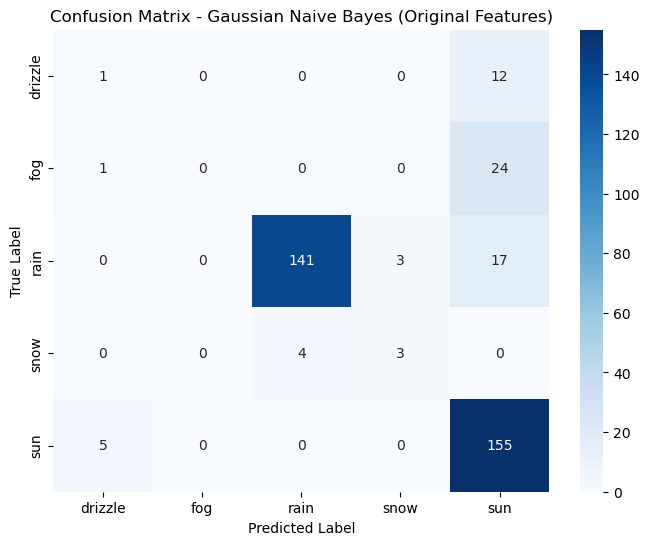


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.14      0.08      0.10        13
         fog       0.00      0.00      0.00        25
        rain       0.97      0.88      0.92       161
        snow       0.50      0.43      0.46         7
         sun       0.75      0.97      0.84       160

    accuracy                           0.82       366
   macro avg       0.47      0.47      0.47       366
weighted avg       0.77      0.82      0.79       366



In [38]:
# %% [markdown]
# ## Model Training and Evaluation

# %%
nb_model_original, nb_accuracy_original = train_and_evaluate_model(
    GaussianNB(), X_train_original, y_train_original, X_test_original, y_test_original,
    le.classes_, "Gaussian Naive Bayes (Original Features)"
)


--- Gaussian Naive Bayes (Lagged Features) Training and Evaluation ---:
Accuracy: 0.7918

Confusion Matrix:


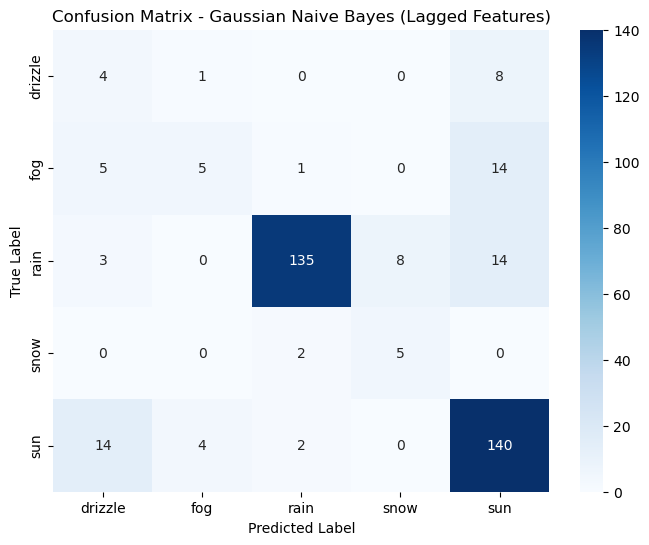


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.15      0.31      0.21        13
         fog       0.50      0.20      0.29        25
        rain       0.96      0.84      0.90       160
        snow       0.38      0.71      0.50         7
         sun       0.80      0.88      0.83       160

    accuracy                           0.79       365
   macro avg       0.56      0.59      0.54       365
weighted avg       0.82      0.79      0.80       365


--- Logistic Regression (Original Features) Training and Evaluation ---:
Accuracy: 0.8224

Confusion Matrix:


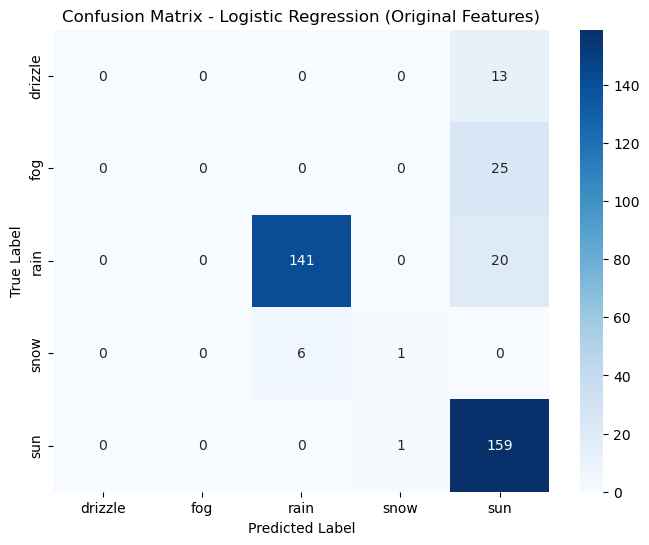


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        13
         fog       0.00      0.00      0.00        25
        rain       0.96      0.88      0.92       161
        snow       0.50      0.14      0.22         7
         sun       0.73      0.99      0.84       160

    accuracy                           0.82       366
   macro avg       0.44      0.40      0.40       366
weighted avg       0.75      0.82      0.78       366


--- Support Vector Machine (Original Features) Training and Evaluation ---:
Accuracy: 0.7705

Confusion Matrix:


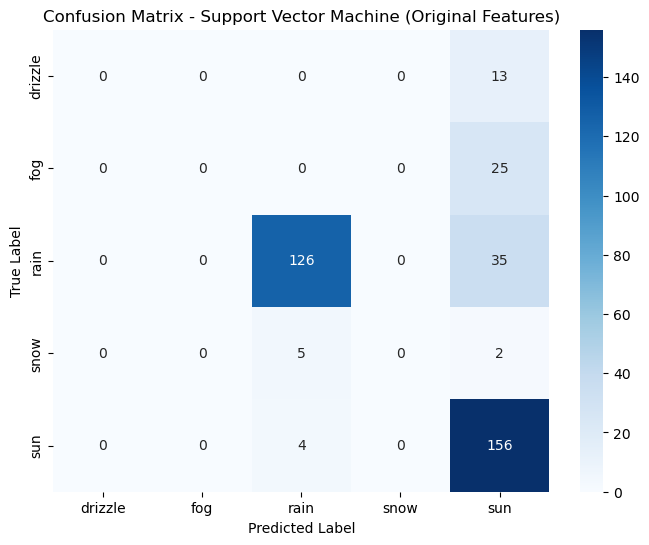


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        13
         fog       0.00      0.00      0.00        25
        rain       0.93      0.78      0.85       161
        snow       0.00      0.00      0.00         7
         sun       0.68      0.97      0.80       160

    accuracy                           0.77       366
   macro avg       0.32      0.35      0.33       366
weighted avg       0.71      0.77      0.72       366



In [39]:
# Ensure le_lagged.classes_ is used for lagged model evaluation if its encoding differs.
# If df['weather'].unique() is consistent, le.classes_ and le_lagged.classes_ will be the same.
nb_model_lagged, nb_accuracy_lagged = train_and_evaluate_model(
    GaussianNB(), X_train_lagged, y_train_lagged, X_test_lagged, y_test_lagged,
    le_lagged.classes_, "Gaussian Naive Bayes (Lagged Features)"
)

lr_model_original, lr_accuracy_original = train_and_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42), X_train_original, y_train_original, X_test_original, y_test_original,
    le.classes_, "Logistic Regression (Original Features)"
)

svm_model_original, svm_accuracy_original = train_and_evaluate_model(
    SVC(random_state=42), X_train_original, y_train_original, X_test_original, y_test_original,
    le.classes_, "Support Vector Machine (Original Features)"
)


In [40]:
# %% [markdown]
# ## Ablation Study

# %%
features_to_ablate = [
    ['temp_min', 'temp_max', 'precipitation', 'wind'],
    ['temp_min', 'temp_max', 'precipitation'],
    ['temp_min', 'temp_max', 'wind'],
    ['precipitation', 'wind'],
    ['temp_max', 'precipitation', 'wind'],
    ['temp_min', 'precipitation', 'wind'],
    ['temp_max'],
    ['wind']
]

ablation_results = {}

In [41]:
print_header("--- Ablation Study (Gaussian Naive Bayes with Original Features) ---")
for i, current_features in enumerate(features_to_ablate):
    print(f"\nTraining with features: {current_features}")
    X_ablation = df_processed[current_features]
    y_ablation = df_processed['weather_encoded']

    # --- Feedback Implementation: Train/Test Split ratio ---
    # Changed test_size from 0.2 to 0.25
    X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(
        X_ablation, y_ablation, test_size=0.25, random_state=42, stratify=y_ablation
    )

    model = GaussianNB()
    model.fit(X_train_ab, y_train_ab)
    y_pred_ab = model.predict(X_test_ab)
    accuracy_ab = accuracy_score(y_test_ab, y_pred_ab)
    ablation_results[tuple(current_features)] = accuracy_ab
    print(f"Accuracy: {accuracy_ab:.4f}")


--- Ablation Study (Gaussian Naive Bayes with Original Features) ---:

Training with features: ['temp_min', 'temp_max', 'precipitation', 'wind']
Accuracy: 0.8197

Training with features: ['temp_min', 'temp_max', 'precipitation']
Accuracy: 0.8306

Training with features: ['temp_min', 'temp_max', 'wind']
Accuracy: 0.5956

Training with features: ['precipitation', 'wind']
Accuracy: 0.8306

Training with features: ['temp_max', 'precipitation', 'wind']
Accuracy: 0.8306

Training with features: ['temp_min', 'precipitation', 'wind']
Accuracy: 0.8333

Training with features: ['temp_max']
Accuracy: 0.6202

Training with features: ['wind']
Accuracy: 0.5410


In [42]:
print_header("--- Ablation Study Summary ---")
for features, acc in ablation_results.items():
    print(f"Features: {features} -> Accuracy: {acc:.4f}")


--- Ablation Study Summary ---:
Features: ('temp_min', 'temp_max', 'precipitation', 'wind') -> Accuracy: 0.8197
Features: ('temp_min', 'temp_max', 'precipitation') -> Accuracy: 0.8306
Features: ('temp_min', 'temp_max', 'wind') -> Accuracy: 0.5956
Features: ('precipitation', 'wind') -> Accuracy: 0.8306
Features: ('temp_max', 'precipitation', 'wind') -> Accuracy: 0.8306
Features: ('temp_min', 'precipitation', 'wind') -> Accuracy: 0.8333
Features: ('temp_max',) -> Accuracy: 0.6202
Features: ('wind',) -> Accuracy: 0.5410


In [43]:
# %% [markdown]
# ## Save the Model for Flask App

# %%
joblib.dump(nb_model_original, 'weather_prediction_model.joblib')
print_header("Saved weather_prediction_model.joblib (Gaussian Naive Bayes with original features)")


Saved weather_prediction_model.joblib (Gaussian Naive Bayes with original features):


In [44]:
# %% [markdown]
# ## Note on Further Model Exploration (Feedback Suggestion)
#
# The feedback included a suggestion to explore a Random Forest classifier.
# Random Forests can be powerful and offer insights into feature importance.
#
# Key benefits:
# - Often provide good performance with less hyperparameter tuning.
# - Can handle a mix of numerical and categorical features (though scikit-learn requires encoding).
# - Provide `feature_importances_` attribute, which can be used to understand which features the model found most predictive. This automates some aspects of an ablation study or feature selection.
# - Generally robust to overfitting, especially with more trees.
#
# This would be a good next step to potentially improve predictive performance and gain further insights from the data.
# You could train it similarly to the other models:
#
# ```python
# from sklearn.ensemble import RandomForestClassifier
#
# # rf_model, rf_accuracy = train_and_evaluate_model(
# # RandomForestClassifier(random_state=42, n_estimators=100),
# # X_train_original, y_train_original, X_test_original, y_test_original,
# # le.classes_, "Random Forest (Original Features)"
# # )
# # print(f"Random Forest Feature Importances: {rf_model.feature_importances_}")
# ```

# %%
print_header("Notebook execution complete!")


Notebook execution complete!:
